In [20]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance


CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


In [9]:
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000)

## tuning just on training data
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

## what if tuned in all data?
X_train = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - CIP_data_no_drop['Susceptible']

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 1, .01) #[0.001, 0.01, 0.1, 1, 10, 100, 1000] #np.arange(0, 1000, 1) #loguniform(1e-5, 100)

search = RandomizedSearchCV(model_lr, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.75}

/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_ini

Best Score: 0.802136720303136
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.33}


In [18]:
##### HYPERPARAMETER TUNING 
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.75, penalty = 'l2')

## Temporal split training data 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

model_fit = model_lr.fit(X_train, y_train)

#test data: 2009 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']

y_predict = model_lr.predict(X_test)

ROC_AUC_logistic_regression= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_lr:', ROC_AUC_logistic_regression) 

print(ROC_AUC_logistic_regression)#
perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

ROC_AUC_lr: 0.6025349420260399
0.6025349420260399


Weight,Feature
0.0647 ± 0.0010,PREV_CLINIC
0.0609 ± 0.0021,PREV_REGION
0.0266 ± 0.0014,MSW
0.0242 ± 0.0016,MSM
0.0037 ± 0.0015,DELTA_REGION
0.0027 ± 0.0008,MSMW
0.0025 ± 0.0003,Northeast
0.0018 ± 0.0008,Midwest
-0.0004 ± 0.0003,Southwest
-0.0004 ± 0.0003,Oth/Unk/Missing


In [21]:
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Prev. Region', 'Prev. Clinic','Change']

PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 100, random_state = 42)
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']
for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}"
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")

Prev. Clinic0.064 +/- 0.001
Prev. Region0.060 +/- 0.001
MSW     0.026 +/- 0.001
MSM     0.024 +/- 0.001
Change  0.005 +/- 0.001
Northeast0.003 +/- 0.000
MSMW    0.003 +/- 0.000
Midwest 0.002 +/- 0.001
Southwest-0.000 +/- 0.000
Oth/Unk/Missing-0.000 +/- 0.000
Southeast-0.007 +/- 0.000
West    -0.015 +/- 0.001


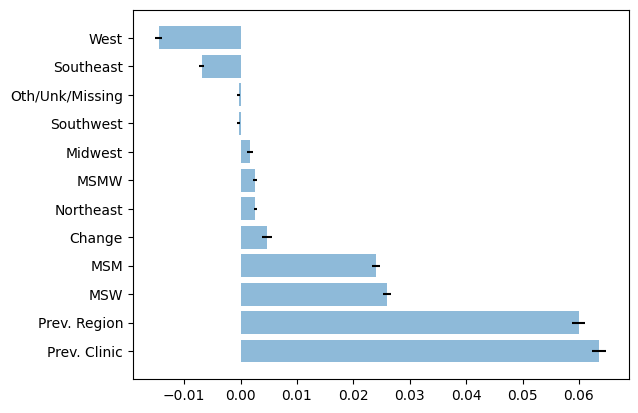

In [22]:
### graph feature engineering results 
feature_names = np.array(feature_names)
feature_names_by_importance = feature_names[PI.importances_mean.argsort()[::-1]]
mean_importance_by_importance = PI.importances_mean[PI.importances_mean.argsort()[::-1]]
std_importance_by_importance = PI.importances_std[PI.importances_mean.argsort()[::-1]]

plt.barh(y = range(mean_importance_by_importance.size), width =mean_importance_by_importance,
 xerr= std_importance_by_importance, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
plt.yticks(range(feature_names_by_importance.size), feature_names_by_importance)

#plt.savefig('Graphs/Features_by_importance_post_hyperparameter_logistic_regression.png')

In [23]:
##### HYPERPARAMETER TUNING without west and southeast

model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000)

## tuning just on training data
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

## what if tuned in all data?
X_train = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - CIP_data_no_drop['Susceptible']

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 1, .01) #[0.001, 0.01, 0.1, 1, 10, 100, 1000] #np.arange(0, 1000, 1) #loguniform(1e-5, 100)

search = RandomizedSearchCV(model_lr, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on thes

Best Score: 0.800936565458467
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.27}


In [50]:
###### Specificity and sensitivity of model on entire dataset
###### Dropping west and southeast

model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

#loop setup
threshold_seq = np.linspace(0,1,101)

#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']

 #1. Create model using all data and get the apparent sensitivity and specificty 

model_fit_train = model_lr.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

ROC_AUC_logistic_regression= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_lr:', ROC_AUC_logistic_regression) 
#dataframes
sensitivity_test_threshold = []
specificity_test_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  #print(threshold)
 
 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  # Save results
  sensitivity_test_threshold.append(sensitivity_test)
  specificity_test_threshold.append(specificity_test)

ROC_AUC_lr: 0.6206361149039198


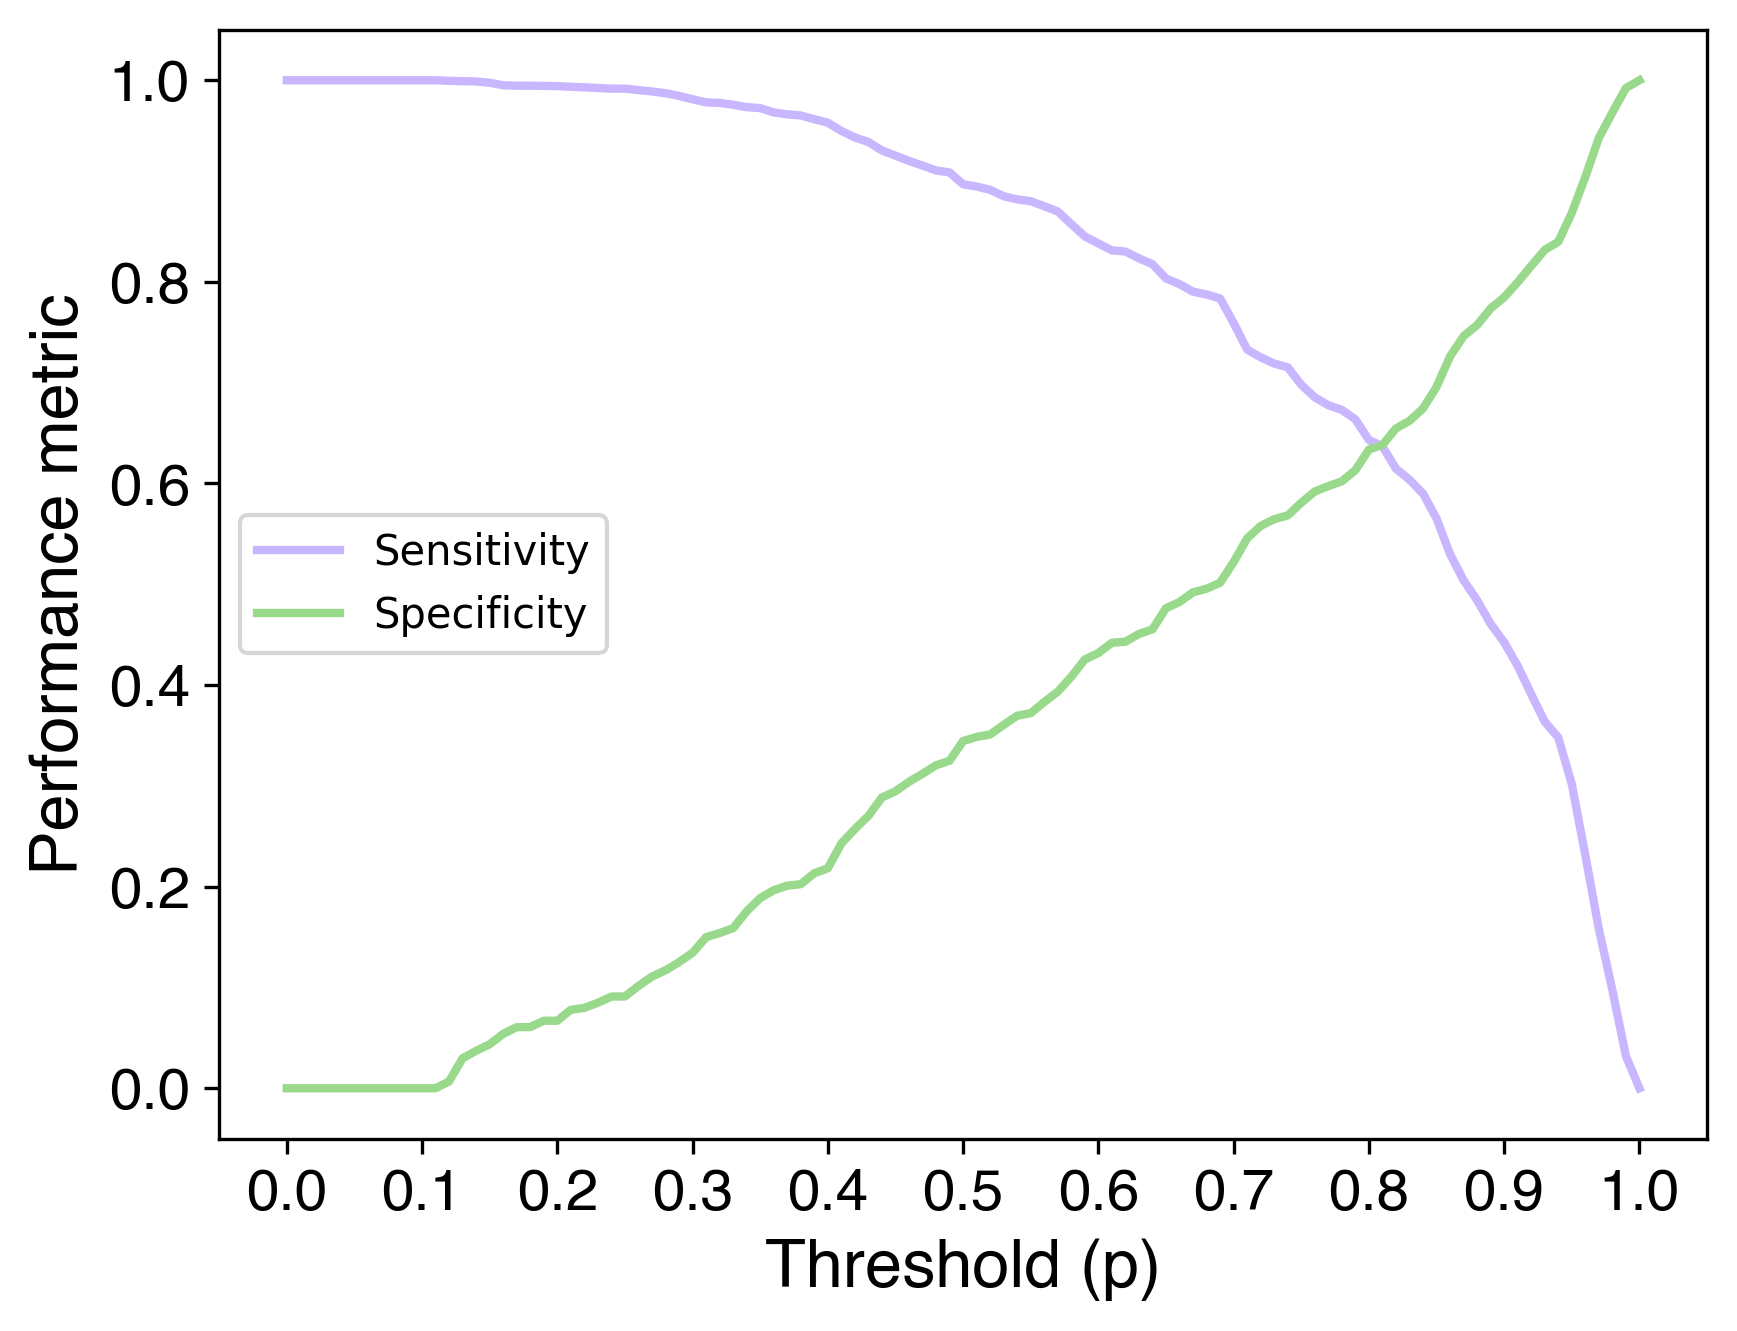

In [51]:
##### Graph of sensitivity and specificity 
hfont = {'fontname':'Helvetica'}

plt.rcParams['figure.dpi'] = 300
#plt.figure(figsize=(5.4,3.8))
sensitivity_test_threshold = pd.DataFrame(sensitivity_test_threshold)
specificity_test_threshold = pd.DataFrame(specificity_test_threshold)
threshold_seq = np.linspace(0,1,101)

plt.plot(threshold_seq, sensitivity_test_threshold, color = "#c8b6ff", label = "Sensitivity", linewidth = 2)
plt.plot(threshold_seq, specificity_test_threshold, color = "#99d98c", label = "Specificity", linewidth = 2)
#plt.errorbar(threshold_seq, specificity_test_table, yerr = y_err_sensitivity, ecolor="lightblue")

plt.xlabel("Threshold (p)", fontsize=16, **hfont)
plt.ylabel("Performance metric", fontsize=16,**hfont)
plt.xticks(np.linspace(0,1,11), fontsize=14,**hfont)
plt.yticks(np.linspace(0,1,6), fontsize=14,**hfont)

plt.legend()
#plt.savefig('Graphs/Sensitivity_specificity_all_workflow_paper_logistic_regression.png')

In [29]:
###### Cipro prevalence 2011-2019
cipro_R_prev_all= y_test.sum()/len(y_test) #get prevalence overall before radndom oversampling
print(cipro_R_prev_all)

0.23081886682486158


In [52]:
########### Now do proportion receiving effective and unnecessary treatment for overall testing data
### can use model from the previous cell 

### Loop over thresholds to see how classification threshold affects proportion receiving effective and unnecessary treatment ALL TEST DATA
threshold_seq = np.linspace(0,1,101)

get_effective_threshold = []
incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  get_effective_threshold.append(sensitivity_test * cipro_R_prev_all + (1 -  cipro_R_prev_all)) #q_p
  incorrectly_get_X_threshold.append((1 - cipro_R_prev_all) * (1 - specificity_test)) #c_p

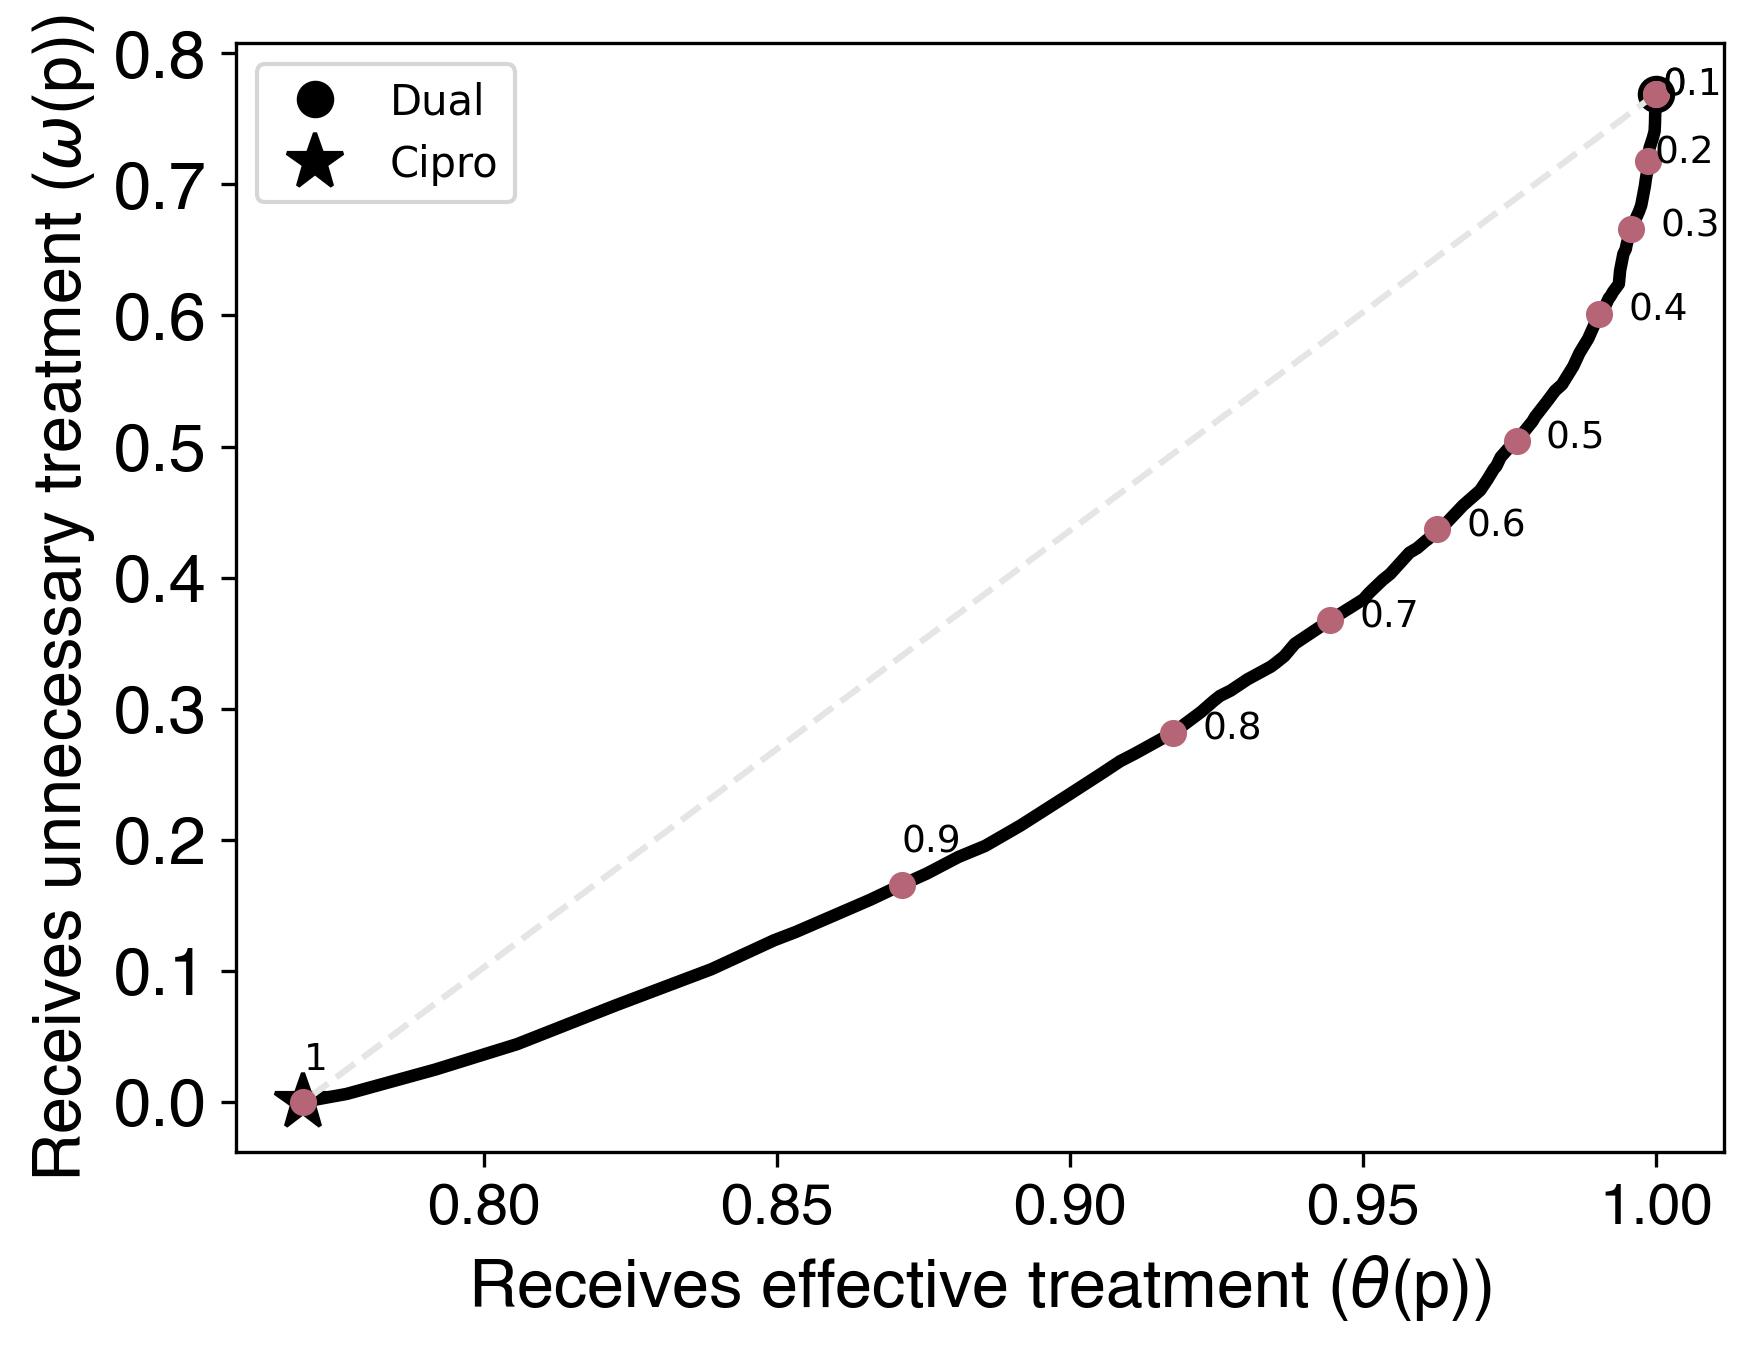

In [54]:
### Plotting overall proportion receiving effective and unnecessary treatment with all training data 

plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)

plt.xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)
plt.ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
plt.xticks(np.linspace(0,1,21), fontsize=14, **hfont)
plt.yticks(np.linspace(0,1,11), fontsize=16, **hfont)

plt.rcParams['figure.dpi'] = 300

plt.plot(1, 1 - cipro_R_prev_all, marker='.', ls='none', ms=16, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_all), 0, marker='*', ls='none', ms=14, color = "black", label = "Cipro")
plt.plot([1, 1-cipro_R_prev_all], [1-cipro_R_prev_all, 0], color = "#e5e5e5", linestyle="--")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
    if get_effective_threshold[index] > 0.996:
        plt.text(get_effective_threshold[index] + 0.001, incorrectly_get_X_threshold[index] - 0.001, text_for_graph[x], size = 9)
    elif (get_effective_threshold[index] > 0.9) & (get_effective_threshold[index] < 0.996):
        plt.text(get_effective_threshold[index] + 0.005, incorrectly_get_X_threshold[index] - 0.005, text_for_graph[x], size = 9)
    else:
        plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x], size = 9)
    x = x+1

#plt.savefig('Graphs/Proportion_effective_unnecessary_all_workflow_paper_logistic_regression.png')

/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

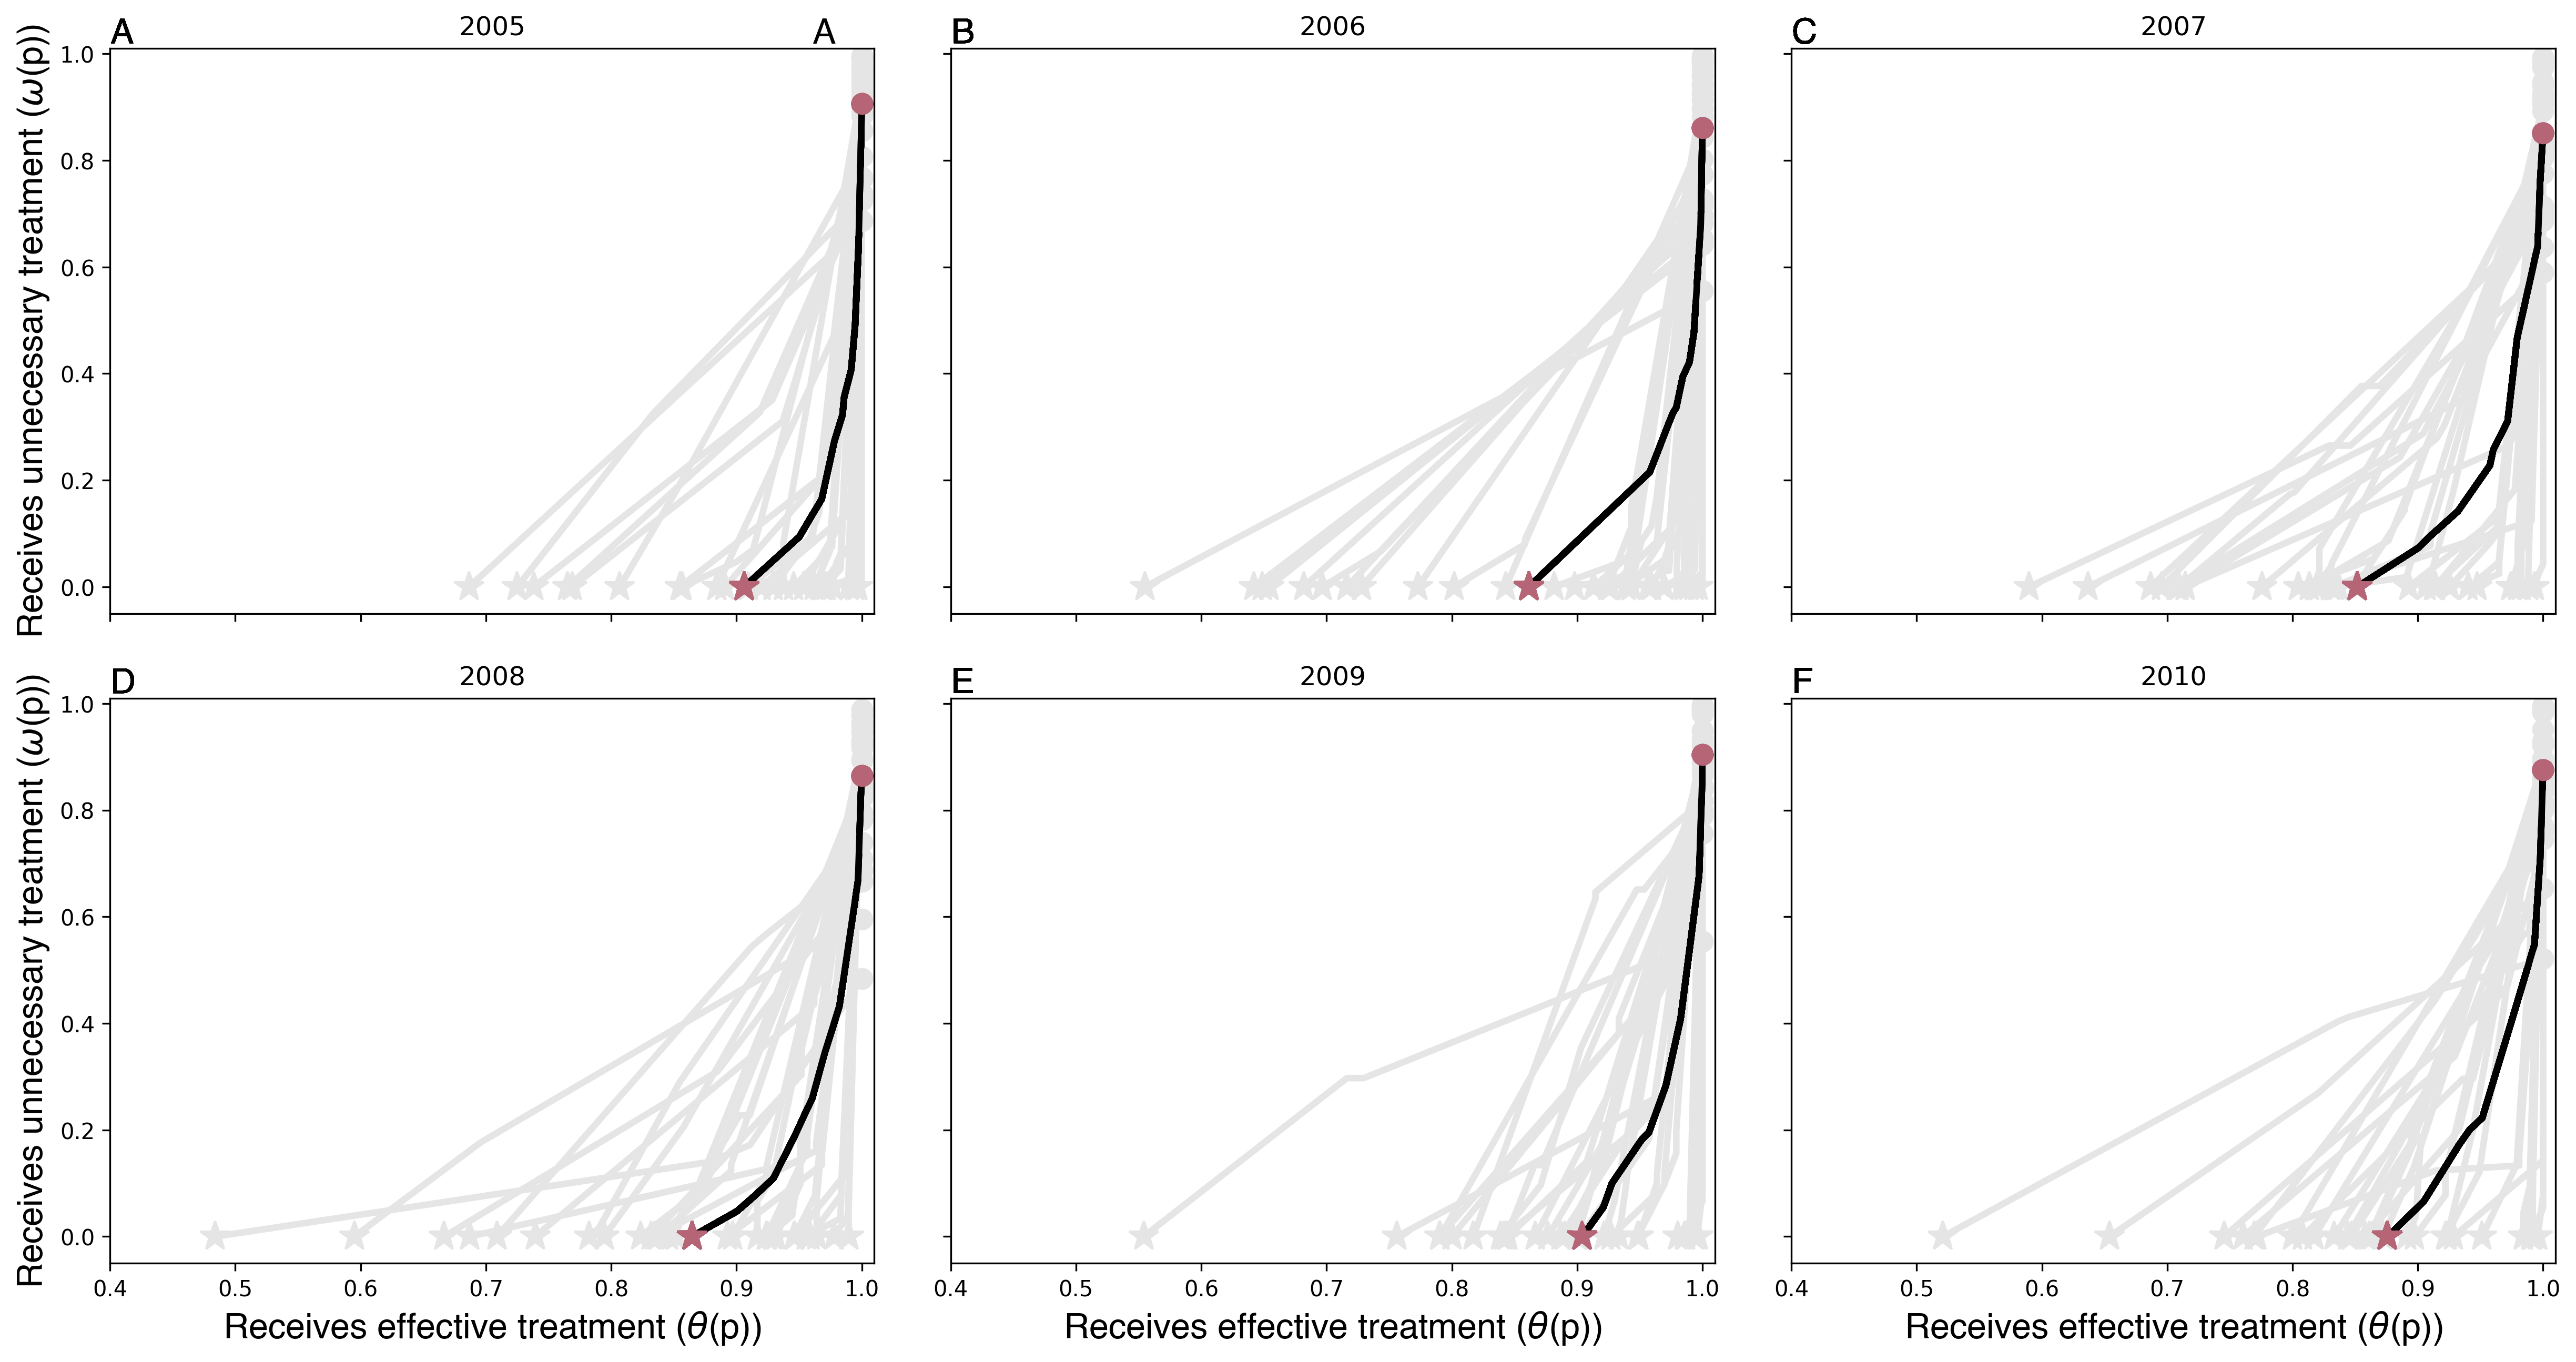

In [96]:
########### Now do proportion receiving effective and unnecessary treatment for years surrounding 2007 decision 
### now do a loop over different years to get the proportion receiving effective and unnecessary treatment 
### has LOOCV 
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
## NEEDED FOR HYPERPARAMETER TUNING   
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 1, .01) #[0.001, 0.01, 0.1, 1, 10, 100, 1000] #np.arange(0, 1000, 1) #loguniform(1e-5, 100)



#### Loop set up 
test_years = [2005, 2006, 2007, 2008, 2009, 2010]
labels = ["A", "B", "C", "D", "E", "F" ]
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')



fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
for year in test_years: 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
    y_train = 1 - train_data['Susceptible']
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
    y_test = 1 - test_data['Susceptible']
    cipro_R_prev = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
    ## before fitting the model, do hyperparameter tuning 
    search = RandomizedSearchCV(model_lr, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
    result = search.fit(X_train, y_train)

    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = result.best_params_['solver'], C = result.best_params_['C'], penalty = result.best_params_['penalty'])

    ## fit model w/hyperparameters 
    model_fit_train = model_lr.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    get_effective_threshold_prev_5 = []
    incorrectly_get_X_threshold_prev_5 = [] #no bootstrapping, no 95% CI 

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
    
        get_effective_threshold_prev_5.append(sensitivity_test * cipro_R_prev + (1 -  cipro_R_prev)) #q_p
        incorrectly_get_X_threshold_prev_5.append((1 - cipro_R_prev) * (1 - specificity_test)) #c_p
    x = 0
    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
          #train data - does not have clinic
        X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)
        if cipro_R > 0: 
          try:

          # test 
              model_fit_train = model_lr.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_region = []
              incorrectly_get_X_threshold_region  = []
              for threshold in threshold_seq:

                y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

                tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

                sensitivity_test  = tp_test  / (tp_test   + fn_test )
                specificity_test   = tn_test / (tn_test + fp_test )
                get_effective_threshold_region.append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
                incorrectly_get_X_threshold_region.append((1 - cipro_R) * (1 - specificity_test)) #c_p
              axs[i].plot(get_effective_threshold_region, incorrectly_get_X_threshold_region,color = "#e5e5e5", linewidth = 3)
              #axs[i].plot([1, 1-cipro_R], [1-cipro_R, 0], color = "#e5e5e5", linestyle="--")

              if (i == 0) | (i == 3):
                axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
              if(i == 3) | (i == 4) | (i == 5):
                axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)

              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
              axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 0.01, labels[i], fontsize = 16, **hfont)
              axs[i].title.set_text(year)

          
          except ValueError:
            try:

            # test 
              model_fit_train = model_lr.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              get_effective_threshold_region = []
              incorrectly_get_X_threshold_region  = []
              for threshold in threshold_seq:

                y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

                tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

                sensitivity_test  = tp_test  / (tp_test   + fn_test )
                specificity_test   = tn_test / (tn_test + fp_test )
  
                get_effective_threshold_region.append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
                incorrectly_get_X_threshold_region.append((1 - cipro_R) * (1 - specificity_test)) #c_p
              x = 0
              axs[i].plot(get_effective_threshold_region, incorrectly_get_X_threshold_region,color = "black", linewidth = 3)
              axs[i].plot([1, 1-cipro_R], [1-cipro_R, 0], color = "#e5e5e5", linestyle="--")

              if (i == 0) | (i == 3):
                axs[i].set_ylabel("Receives unnecessary treatment ($\omega$(p))", fontsize=16, **hfont)
              if(i == 3) | (i == 4) | (i == 5):
                axs[i].set_xlabel(r"Receives effective treatment ($\theta$(p))", fontsize=16, **hfont)

              axs[i].plot(1, 1 - cipro_R, marker='.', ls='none', ms=18, color = "#e5e5e5")
              axs[i].plot((1-cipro_R), 0, marker='*', ls='none', ms=14, color = "#e5e5e5")
              axs[i].title.set_text(year)


              #plt.plot(get_effective_threshold_region , incorrectly_get_X_threshold_region , color = "gray", alpha = 0.5)
              #plt.plot(1, 1 - cipro_R, marker='.', ls='none', ms=10, color = "gray")
              #plt.plot((1-cipro_R), 0, marker='*', ls='none', ms=10, color = "gray")
            except ValueError:
              print('x')
              pass
          axs[i].plot(get_effective_threshold_prev_5, incorrectly_get_X_threshold_prev_5,color = "black", linewidth = 3)
          axs[i].plot(1, 1 - cipro_R_prev, marker='.', ls='none', ms=18, color = "#b56576")
          axs[i].plot((1-cipro_R_prev), 0, marker='*', ls='none', ms=14, color = "#b56576")
          axs[i].set_ylim([0-0.05,1.01])
          axs[i].set_xlim([0.4, 1.01])

    i += 1   
plt.savefig('Proportion_effective_unnecessary_2006_2011_all_workflow_paper_logistic_regression.png')